## Rod Control Example

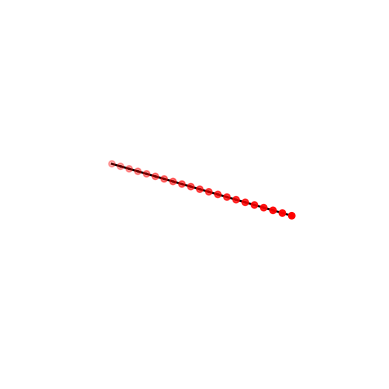

In [1]:
import numpy as np
import dismech

geom = dismech.GeomParams(rod_r0=0.001,
                          shell_h=0)

material = dismech.Material(density=1200,
                            youngs_rod=2e6,
                            youngs_shell=0,
                            poisson_rod=0.5,
                            poisson_shell=0)

dynamic_2d_sim = dismech.SimParams(static_sim=False,
                                  two_d_sim=False,   # no twisting
                                  use_mid_edge=False,
                                  use_line_search=False,
                                  show_floor=False,
                                  log_data=True,
                                  log_step=1,
                                  dt=1e-3,
                                  max_iter=25,
                                  total_time=1,
                                  plot_step=1,
                                  tol=1e-4,
                                  ftol=1e-4,
                                  dtol=1e-2)

env = dismech.Environment()
env.add_force('rft', ct=0.01, cn=0.1)
# env.add_force('gravity', g=np.array([0.0, 0.0, -9.81]))
# env.add_force('damping', eta=0.01)

geo = dismech.Geometry.from_txt('../tests/resources/rod_cantilever/horizontal_rod_n21.txt')

robot = dismech.SoftRobot(geom, material, geo, dynamic_2d_sim, env)

In [2]:
stepper = dismech.ImplicitEulerTimeStepper(robot)

## Reference configuration from npz

In [3]:
# read reference configuration from npz file
ref_data = np.load('snake_kappa_ref.npz')
ref_kappa_traj=ref_data['kappa_traj'] 
ref_times = ref_data['ref_times']
T_ref, Nb, D = ref_kappa_traj.shape

def ref_func(t):
    """
    Return reference kappa at scalar time t as shape (Nb, 2),
    via linear interpolation over ref_times.
    """
    kappa_ref = np.empty((Nb, D), dtype=float)
    for d in range(D):
        for i in range(Nb):
            kappa_ref[i, d] = np.interp(t, ref_times, ref_kappa_traj[:, i, d])
    return kappa_ref


### Time Stepping
PID Control

In [4]:
from dismech.controllers.curvaturePITracker import CurvaturePITracker

# Y=1e6
Kp_kappa = 1
Ki_kappa = 0.5
Kd_kappa = 0.0

nat0 = robot.bend_springs.nat_strain.copy() 
tracker = CurvaturePITracker(
    nat0=nat0,
    ref_func=ref_func,   # <--- use continuous reference
    # DO NOT pass ref_times/ref_values now
    Kp=Kp_kappa, Ki=Ki_kappa, Kd=Kd_kappa, beta=1,
    du_rate_per_step=0.2,
    kappa_mag_max=np.inf, antiwindup_bc=0.9,
    smooth_alpha=0.01
)


dt = dynamic_2d_sim.dt
bend_energy = None
sat_flags = []

# Make a before_step callback that calls the controller each step
be = stepper.elastic_energies['bend']
dt = robot.sim_params.dt  # your dt

def actuate_track(robot, t):
    kappa_meas = be.get_strain(robot.state)                       # (Nb,2)
    nat = robot.bend_springs.nat_strain                           # (Nb,2), updated in-place
    nat_before = nat.copy()
    tracker.update(t, kappa_meas, nat, dt)                        # writes into nat
    sat_flags.append(np.linalg.norm(nat - nat_before) >= tracker.du_rate*0.99)  # rate sat proxy

    return robot


In [5]:
robot0 = robot

stepper.before_step = actuate_track
robots, t_arr, f_norms = stepper.simulate()
robots = [robot0] + robots # stack robot0 with the robots

qs = np.stack([robot.state.q for robot in robots])
t_arr = np.array([0, *t_arr])

iter: 1, error: 0.000
current_time:  0.001
iter: 1, error: 0.000
current_time:  0.002
iter: 1, error: 0.000
current_time:  0.003
iter: 1, error: 0.000
current_time:  0.004
iter: 1, error: 0.000
current_time:  0.005
iter: 1, error: 0.000
current_time:  0.006
iter: 1, error: 0.000
current_time:  0.007
iter: 1, error: 0.000
current_time:  0.008
iter: 1, error: 0.000
current_time:  0.009000000000000001
iter: 1, error: 0.000
current_time:  0.010000000000000002
iter: 1, error: 0.000
current_time:  0.011000000000000003
iter: 1, error: 0.005
iter: 2, error: 0.004
current_time:  0.012000000000000004
iter: 1, error: 0.006
iter: 2, error: 0.008
current_time:  0.013000000000000005
iter: 1, error: 0.009
iter: 2, error: 0.013
current_time:  0.014000000000000005
iter: 1, error: 0.011
iter: 2, error: 0.016
iter: 3, error: 0.000
current_time:  0.015000000000000006
iter: 1, error: 0.014
iter: 2, error: 0.020
iter: 3, error: 0.000
current_time:  0.016000000000000007
iter: 1, error: 0.016
iter: 2, error: 

In [6]:
print("t_arr shape:", t_arr.shape)
options = dismech.AnimationOptions(title='Rod PID', plot_step=10)

fig = dismech.get_interactive_animation_plotly(robot, t_arr, qs, options)
fig.show()

t_arr shape: (1002,)


In [7]:
import numpy as np

# 1) Extract κ_ref(t) from the teacher rollout
def extract_kappa_traj_from_robots(robots, stepper):
    be = stepper.elastic_energies['bend']     # your BendEnergy
    kappas = []
    for rb in robots:
        # BendEnergy.get_strain expects RobotState
        kappa = be.get_strain(rb.state)       # shape (Nb,2)
        kappas.append(kappa.astype(np.float64))
    kappas = np.stack(kappas, axis=0)         # (T, Nb, 2)
    return kappas


kappa_traj = extract_kappa_traj_from_robots(robots, stepper)
T_sim, Nb, D = kappa_traj.shape
ref_on_sim_grid = np.empty_like(kappa_traj)

for k, t in enumerate(t_arr):
    ref_on_sim_grid[k] = ref_func(t)   # (Nb,2) from the same ref_func

if kappa_traj.shape != ref_on_sim_grid.shape:
    print("Shape of kappa_traj:", kappa_traj.shape)
    print("Shape of ref_on_sim_grid:", ref_on_sim_grid.shape)
    raise ValueError("kappa_traj and ref_on_sim_grid must have the same shape for error calculation.") 
err = kappa_traj - ref_on_sim_grid

# find rmse error over time
bend_strain_errors = np.sqrt(np.mean(err**2, axis=(1,2)))
print("RMSE between extracted kappa_traj and ref_on_sim_grid over time:", bend_strain_errors)

# mean error over time instead of rmse
bend_strain_errors_mean = np.mean(np.abs(err), axis=(1,2))
print("Mean absolute error between extracted kappa_traj and ref_on_sim_grid over time:", bend_strain_errors_mean)


RMSE between extracted kappa_traj and ref_on_sim_grid over time: [0.         0.         0.         ... 0.00060688 0.00060582 0.00060417]
Mean absolute error between extracted kappa_traj and ref_on_sim_grid over time: [0.         0.         0.         ... 0.00036687 0.0003649  0.00036259]


In [8]:
print((bend_strain_errors.shape))

(1002,)


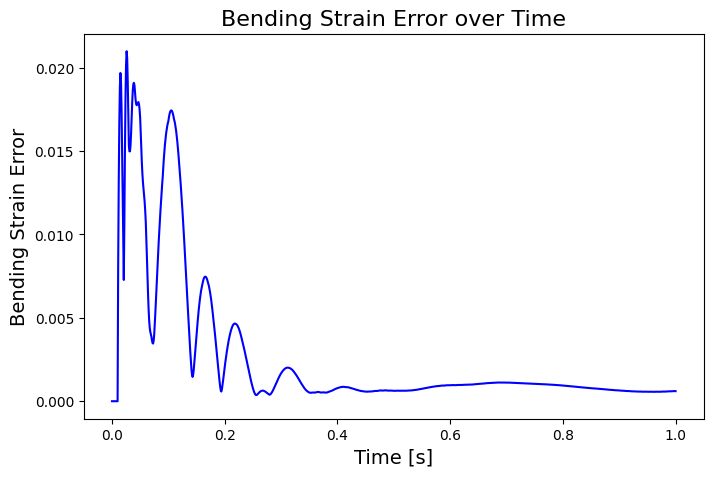

In [9]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# plot bending strain error over time
plt.figure(figsize=(8,5))
plt.plot(t_arr[:], bend_strain_errors, label='Bending Strain Error', color='blue')
plt.xlabel('Time [s]', fontsize=14)
plt.ylabel('Bending Strain Error', fontsize=14)
plt.title('Bending Strain Error over Time', fontsize=16)
# plt.grid(True)
# plt.legend(fontsize=12)
# plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.show()

# save bending strain error in xls file
import pandas as pd 
df = pd.DataFrame({'Time (s)': t_arr[:], 'Bending Strain Error': bend_strain_errors})
df.to_excel('bending_strain_error_pid_tracker.xlsx', index=False)

In [10]:
# calculate steady state error as average over last 10% of time
steady_state_start_index = int(0.9 * len(bend_strain_errors))
steady_state_error = np.mean(bend_strain_errors[steady_state_start_index:])
percentage_steady_state_error = (steady_state_error / np.max(ref_on_sim_grid)) * 100
print("Steady state bending strain error (average over last 10% of time):", percentage_steady_state_error)

Steady state bending strain error (average over last 10% of time): 0.28477257375149373


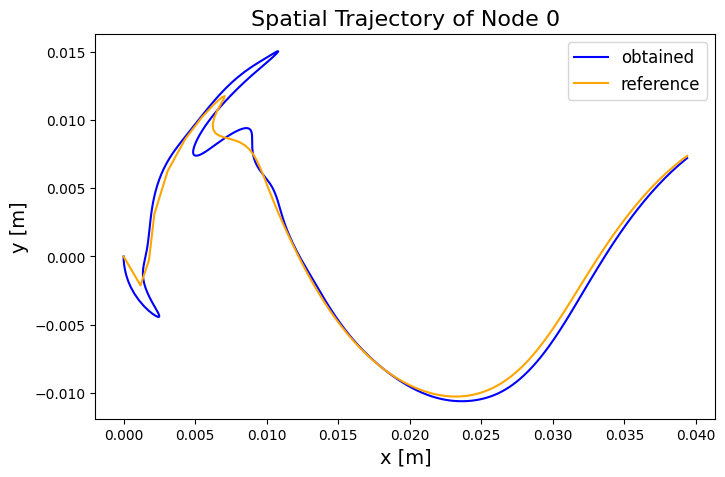

In [11]:
# plot spatial trajectories
ref_data_node0x = np.loadtxt('snake_node0_x_trajectory.txt')
ref_data_node0y = np.loadtxt('snake_node0_y_trajectory.txt')
plt.figure(figsize=(8,5))
plt.plot(qs[:, 0], qs[:,1], label='obtained', color='blue')
plt.plot(ref_data_node0x, ref_data_node0y, label='reference', color='orange')
plt.xlabel('x [m]', fontsize=14)
plt.ylabel('y [m]', fontsize=14)
plt.title('Spatial Trajectory of Node 0', fontsize=16)
# plt.grid(True)
plt.legend(fontsize=12)
plt.show()

# save spatial trajectories in xls file
import pandas as pd 
df = pd.DataFrame({'Obtained X': qs[:, 0], 'Obtained Y': qs[:,1]})
df.to_excel('spatial_trajectories_obtained_only.xlsx', index=False)

df = pd.DataFrame({'Reference X': ref_data_node0x, 'Reference Y': ref_data_node0y})
df.to_excel('spatial_trajectories_reference_only.xlsx', index=False)

In [12]:
sat_frac = np.mean(sat_flags)
print("Saturation fraction:", sat_frac)

Saturation fraction: 0.0


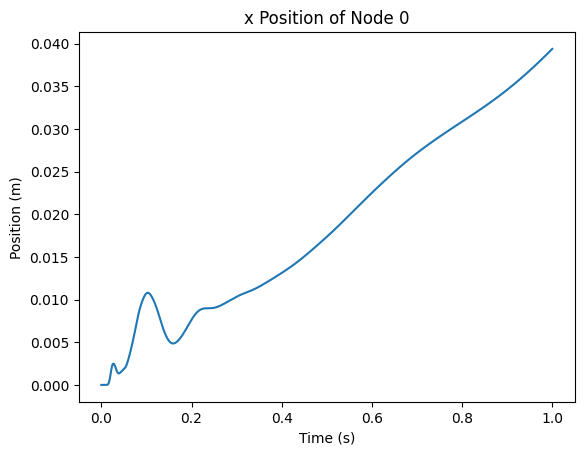

In [13]:
import matplotlib.pyplot as plt
plt.title("x Position of Node 0")
plt.xlabel("Time (s)")
plt.ylabel("Position (m)")
plt.plot(t_arr, qs[:, 0])
plt.show()

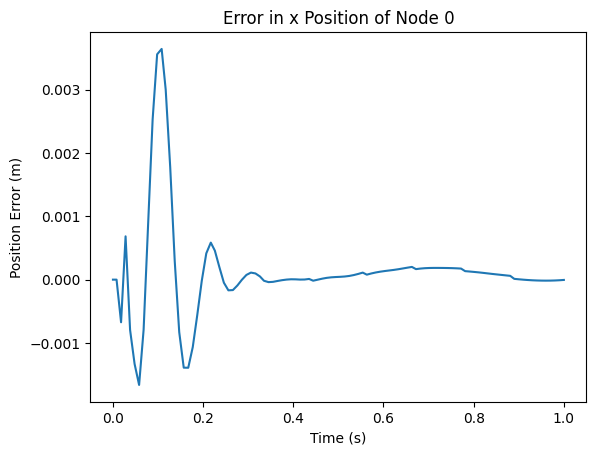

In [14]:
ref_data_node0 = np.loadtxt('snake_node0_x_trajectory.txt')

sim_x = qs[:, 0]              # (T_sim,)
T_sim = sim_x.shape[0]
T_ref = ref_data_node0.shape[0]

# Build integer indices that map reference samples to simulation samples
idx = np.linspace(0, T_sim - 1, T_ref).astype(int)   # length T_ref

sim_x_on_ref = sim_x[idx]      # (T_ref,)
error_node0   = sim_x_on_ref - ref_data_node0

# If you have the time array t_arr from the simulation:
t_on_ref = t_arr[idx]

import matplotlib.pyplot as plt
plt.figure()
plt.title("Error in x Position of Node 0")
plt.xlabel("Time (s)")
plt.ylabel("Position Error (m)")
plt.plot(t_on_ref, error_node0)
plt.show()


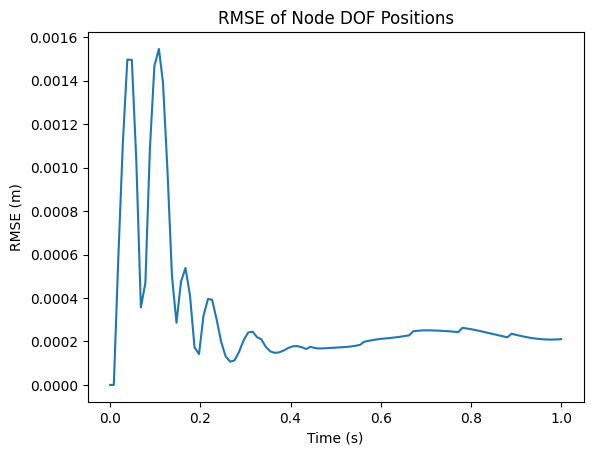

In [15]:
# plot position error RMSE for the node dofs

ref_data_node_all = np.load('snake_dof_trajectory.npz')
ref_dof_traj = ref_data_node_all['qs']      # shape (T_ref, Ndof_ref)

# Simulation data
sim_qs   = qs[:, 0:robot.end_node_dof_index]   # shape (T_sim, Ndof_ref)
T_sim    = sim_qs.shape[0]
T_ref    = ref_dof_traj.shape[0]

# Build indices to sample simulation at T_ref points
idx = np.linspace(0, T_sim - 1, T_ref).astype(int)   # (T_ref,)

sim_qs_on_ref = sim_qs[idx, :]            # (T_ref, Ndof_ref)
err_dof       = sim_qs_on_ref - ref_dof_traj  # (T_ref, Ndof_ref)

# RMSE over DOFs at each time
rmse_dof = np.sqrt(np.mean(err_dof**2, axis=1))   # (T_ref,)

# Time on the same grid
t_on_ref = t_arr[idx]

import matplotlib.pyplot as plt
plt.figure()
plt.title("RMSE of Node DOF Positions")
plt.xlabel("Time (s)")
plt.ylabel("RMSE (m)")
plt.plot(t_on_ref, rmse_dof)
plt.show()


In [16]:
from dismech.logging import logDataForRendering
t=t_arr[::10] # sampled time_array
qs = qs[::10]  # sampled qs
rod_data, shell_data = logDataForRendering(qs, t.reshape(-1, 1), robot, len(t), robot.sim_params.static_sim, robot.map_node_to_dof)

from dismech.logging import export_rod_shell_data
export_rod_shell_data(robot, rod_file='rawDataRod.txt', shell_file='rawDataShell.txt',
                          rod_js='rodData_snake_obtained.js', shell_js='shellData.js',
                          rod_radius=0.06, scaleFactor=10)

(101, 84) (101, 1) (101, 83)
(0,)
0


/home/radha/Desktop/PhD/dismech-python/dismech-python/src/dismech/logging.py:100: UserWarning:

loadtxt: input contained no data: "rawDataShell.txt"

